### Methods and Results

In [1]:
## NOTE: Incorporate this into an earlier part of Methods and Results section ##

## Data Wrangling ##

# Load libraries
library(tidyverse)
library(tidymodels)
library(RColorBrewer)

# Load data from URL
url1 <- "https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"
url2 <- "https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB"

players_original <- read_csv(url1)
sessions_original <- read_csv(url2)

# Generate factor variable for experience level
# unique(players$experience)
experience_levels <- c("Beginner", "Amateur", "Regular", "Veteran", "Pro")

players <- players_original |>
    mutate(experience = factor(experience, levels = experience_levels), # factor variable
          experience1 = case_when(experience == "Beginner" ~ 1,         # numeric variable experience level
                                  experience == "Amateur" ~ 2, 
                                  experience == "Regular" ~ 3,
                                  experience == "Veteran" ~ 4,
                                  experience == "Pro" ~ 5))

# head(players)

# Select variables of interest, remove outliers
players <- players |>
    select(played_hours, age, experience1) |>
    filter(age <= 55 & played_hours <= 6)

# outliers removed given that due to small size of data, outliers have a large impact on the prediction model

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

#### Analysis

##### Overview of the approach
In this section, we perform a K-NN regression given that the relationship is non-linear between age and played hours, and between experience and played hours. We split the data and tune our model on the training set using cross-validation. As part of the model tuning process, we use forward selection by first training a model using only age as the predictor, and then training a multivariable model using both age and experience level as predictors. After determining a model with optimal K and selection of predictors, we evaluate our predictive model on the testing set.

##### Splitting the data
First, we split the players data into training and testing sets using a 70/30 split.

In [2]:
#### K-NN Regression ####

## Model 1: Predicting played hours based on age ##

# set seed
set.seed(234)

# set plot dimensions
options(repr.plot.width = 7, repr.plot.height = 7)

# split the data: 70 training / 30 testing
players_split <- initial_split(players, prop = 0.70, strata = played_hours)
players_training <- training(players_split)
players_testing <- testing(players_split)

##### Cross-validation

We perform a cross-validation to choose an optimal number of neighbours K. First, we create the model specification for tuning our K-NN regression model. Next, we construct the model recipe using played hours as the response variable and age as the predictor variable, with scaled and centered age. We construct a workflow using the recipe and model specification.


In [3]:
# Create model specification
players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")

# Recipe
players_recipe <- recipe(played_hours ~ age, data = players_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# Construct workflow
players_workflow <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec)

players_workflow

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


We consider the size of the training set when choosing the number of cross-validation folds. Given the relatively small size of the data, we take a conservative approach and choose 5 folds. We use the argument *strata = played_hours* to ensure even distributions of the response variable across the 5 folds. We compute the root mean square prediction error (RMSPE) for values of K from 1 to 9, and plot the RMSPE for each value of K.

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,1.0261555,5,0.11970336,Preprocessor1_Model1
2,rmse,standard,1.0209049,5,0.10274717,Preprocessor1_Model2
3,rmse,standard,0.9693610,5,0.10804458,Preprocessor1_Model3
4,rmse,standard,0.9657772,5,0.09949427,Preprocessor1_Model4
5,rmse,standard,0.9562985,5,0.09676147,Preprocessor1_Model5
6,rmse,standard,0.9511467,5,0.09808429,Preprocessor1_Model6
7,rmse,standard,0.9328933,5,0.10059437,Preprocessor1_Model7
8,rmse,standard,0.9321176,5,0.09299947,Preprocessor1_Model8
9,rmse,standard,0.9360861,5,0.08799143,Preprocessor1_Model9


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
8,rmse,standard,0.9321176,5,0.09299947,Preprocessor1_Model8


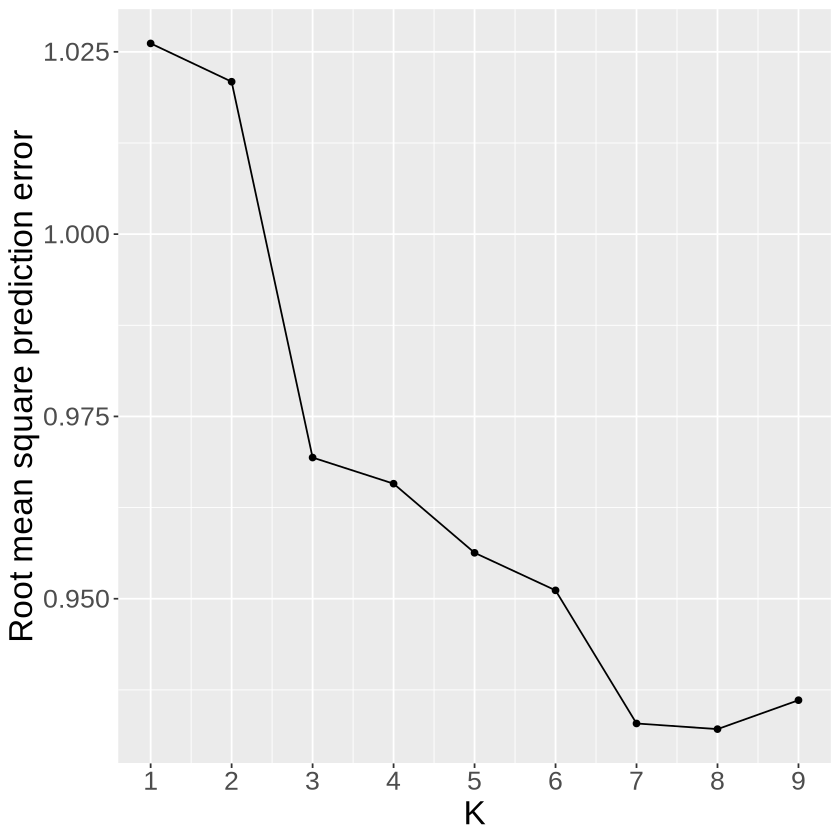

In [4]:
# Specify number of cross-validation folds
players_vfold <- vfold_cv(players_training, v = 5, strata = played_hours)

# Specify number of neighbors to compare
gridvals <- tibble(neighbors = seq(from = 1, to = 9, by = 1))

# Compute RMSPE for different values of K neighbors
players_results <- players_workflow |>
    tune_grid(resamples = players_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse")

players_results

rmspe <- players_results |>
    # filter(.metric == "rmse") |>
    select(neighbors, mean)

# Plot RMSPE vs K
rmspe_plot <- rmspe |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "K", 
         y = "Root mean square prediction error") +
    theme(text = element_text(size=20)) +
    scale_x_continuous(breaks = seq(1,9, by = 1), limits = c(1,9))

rmspe_plot

# Extract minimum RMSPE
players_min <- players_results |>
    filter(.metric == "rmse") |>
    slice_min(order_by = mean, n = 1)

players_min

k_min <- players_min |>
    pull(neighbors)

**Figure X. Relationship between root mean square prediction error and number of neighbors K.**

We obtained a minimum RMSPE value of 0.93 corresponding to K = 8 (**Figure X**). We select K = 8 as the optimal K found by cross-validation and store it as the object k_min.

In [5]:
# Create object for optimal K
k_min <- players_min |>
    pull(neighbors)

##### Forward selection: adding experience level to the model

We investigate whether adding experience as a predictor improves our model (i.e., lowers the RMSPE estimated by cross-validation). We create a new recipe for a multivariable model with both age and experience as predictors, and repeat the tuning process using cross-validation.

In [6]:
## Model 2: Predicting played hours based on age and experience level ##

# Create model specification
# players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
#     set_engine("kknn") |>
#     set_mode("regression")

# Recipe
players_recipe_1 <- recipe(played_hours ~ age + experience1, data = players_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# Construct workflow
players_workflow_1 <- workflow() |>
    add_recipe(players_recipe_1) |>
    add_model(players_spec)

players_workflow_1

# Specify number of cross-validation folds
# players_vfold <- vfold_cv(players_training, v = 5, strata = played_hours)

# Compute RMSPE for different values of K neighbors
# gridvals <- tibble(neighbors = seq(from = 1, to = 9, by = 1))

players_results_1 <- players_workflow_1 |>
    tune_grid(resamples = players_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse")

rmspe_1 <- players_results_1 |>
    # filter(.metric == "rmse") |>
    select(neighbors, mean)

# Find minimum RMSPE
players_min_1 <- players_results_1 |>
    filter(.metric == "rmse") |>
    slice_min(order_by = mean, n = 1)

players_min_1

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
9,rmse,standard,0.9598925,5,0.08731317,Preprocessor1_Model9


Compared to the first model with age as the only predictor, the inclusion of experience level as a predictor results in a higher minimum RMSPE (RMSPE = 0.96 vs RMSPE = 0.93). In other words, including experience level as an additional predictor does not improve our model. Therefore, we proceed with the first model using age as the only predictor.

##### Evaluating the model on the testing set

We create a new K-NN regression model specification using the optimal K that we found in our first model. We create a new workflow using our new model specification and fit a model on the entire training set. We then evaluate our final tuned model on the testing set and output the RMSPE of our predictions on the testing set.

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,0.72330130
rsq,standard,0.05524502
mae,standard,0.42727273


.pred,played_hours,age,experience1
<dbl>,<dbl>,<dbl>,<dbl>
0.025,0.0,17,4
0.550,0.1,21,3
0.550,0.0,21,2
0.025,0.1,17,2
0.075,0.0,22,4
0.025,0.0,17,5


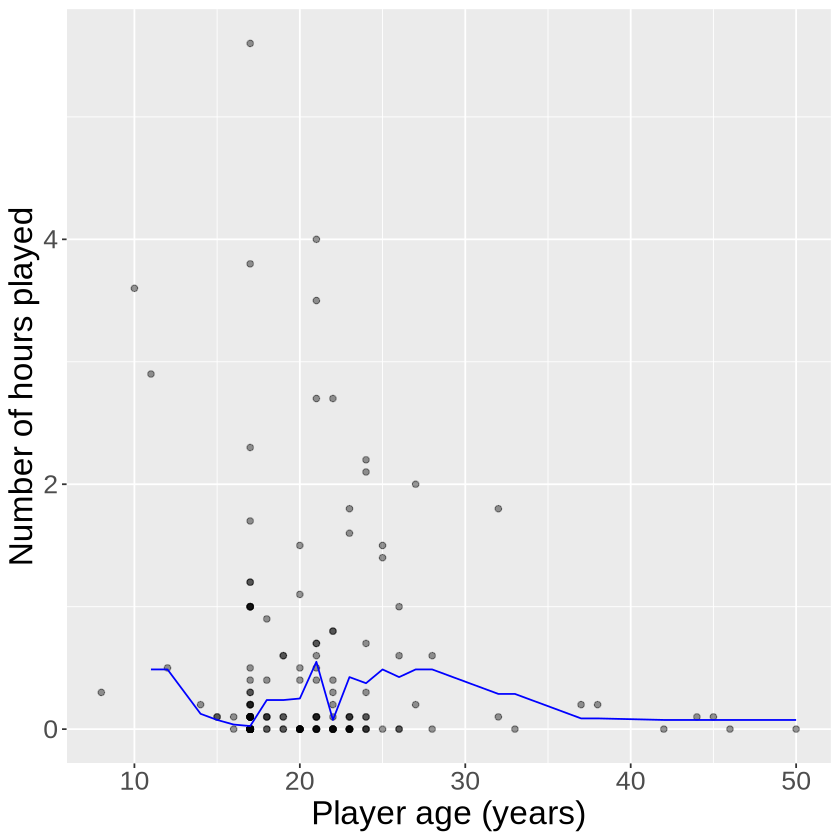

In [7]:
# Create model specification using optimal K
players_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
    set_engine("kknn") |>
    set_mode("regression")

# Create new workflow using best spec and fit on training set
players_best_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_best_spec) |>
    fit(data = players_training)

# Evaluate tuned model on the testing set
players_results <- players_best_fit |>
    predict(players_testing) |>
    bind_cols(players_testing) |>
    metrics(truth = played_hours, estimate =.pred)

players_results

# Plot predictions over the original players data
players_preds <- players_best_fit |>
    predict(players_training) |>
    bind_cols(players_training)

head(players_preds)

players_plot <- ggplot(data = players, aes(x = age, y = played_hours)) +
    geom_point(alpha = 0.4) +
    geom_line(data = players_preds, 
              mapping = aes(x = age, y = .pred),
              color = "blue") + 
    xlab("Player age (years)") +
    ylab("Number of hours played") +
    # ggtitle(paste0("Figure Y: Predictions using K = ", k_min)) +
    theme(text = element_text(size = 20))

players_plot

**Figure Y: Distribution of the number of played hours by player age.** The blue line represents the predictions by the final tuned model (K = 8).

We obtained an RMSPE of 0.72 on the testing set. This can be interpreted as: the predictions on the test data given by our model have an error of approximately +/- 0.72 hours on average. Whether an RMSPE value is “good” depends on the problem. In the context of our research question, Plaicraft is looking for individuals who are more likely to contribute time and game data. A prediction error of around 43 minutes may be considered high, especially given that the majority of registered players contribute less than 1 hour of playing time (75th percentile = 0.6 played hours). Therefore, age may not be considered an accurate predictor of game play hours using the Plaicraft data.